# This script simplifies the morphology operations and adds iris unwrapping
# Daugman alghoritm incoming ...

In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class IrisSegmenter:

    def __init__(self, image_path):

        self.image = cv2.imread(image_path)
        if self.image is None:
            raise ValueError("Cannot load image. Check the path.")
        
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.pupil_center = None
        self.pupil_radius = None
        self.iris_radius = None
        self.iris_center = None
        self.unwrapped_iris = None
                
    def plot_image(self, title, image, cmap='gray'):
        
        if self.show_plots:
            plt.figure(figsize=(6, 6))
            plt.title(title)
            plt.imshow(image, cmap=cmap)
            plt.axis('off')
            plt.show()
            
    def show_projections(self, img, horizontal_projection, vertical_projection, object):

        fig = plt.figure(figsize=(12, 8))

        ax1 = plt.subplot2grid((2, 2), (0, 0))
        ax1.imshow(img, cmap='gray')
        ax1.set_title('Detected object')
        ax1.axis('off')

        ax2 = plt.subplot2grid((2, 2), (0, 1))
        ax2.plot(horizontal_projection, color='black')
        ax2.set_title('Horizontal projection')
        ax2.set_xlabel('Row (y)')
        ax2.set_ylabel('Brightness sum')
        ax2.grid(True)

        ax3 = plt.subplot2grid((2, 2), (1, 0))
        ax3.plot(np.arange(len(vertical_projection)), vertical_projection, color='black')
        ax3.set_title('Vertical projection')
        ax3.set_xlabel('Column (x)')
        ax3.set_ylabel('Brightness sum')
        ax3.grid(True)

        ax4 = plt.subplot2grid((2, 2), (1, 1))
        ax4.axis('off')
        ax4.text(0.5, 0.5, f'{object} projection', ha='center', va='center', fontsize=12)

        plt.tight_layout()
        plt.show()
            
        
    def binarize(self, factor):

        h, w = self.gray.shape
        P = np.sum(self.gray) / (h * w)
        threshold = P / factor
        binary = (self.gray > threshold).astype(np.uint8) * 255
        self.plot_image("Binarized Image", binary)
        return binary
    
    def clean_objects(self, binary_image):

        inverted = cv2.bitwise_not(binary_image)
        contours, _ = cv2.findContours(inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            print("No contours found")
            return binary_image
        
        largest_contour = max(contours, key=cv2.contourArea)
        largest_object = np.zeros_like(inverted)
        cv2.drawContours(largest_object, [largest_contour], -1, 255, -1)
        cleaned = cv2.bitwise_not(largest_object)
        self.plot_image("Cleaned Objects", cleaned)
        return cleaned
    
    def clean_pupil(self, Xp):

        binary_pupil = self.binarize(Xp)
        kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        cleaned = self.clean_objects(binary_pupil)

        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel_large, iterations=2)
        cleaned = cv2.erode(cleaned, kernel_small, iterations=2)
        cleaned = cv2.dilate(cleaned, kernel_small, iterations=2)
        cleaned = cv2.medianBlur(cleaned, 5)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel_large, iterations=2)
        self.plot_image("Cleaned Pupil", cleaned)
        return cleaned

    def detect_pupil(self, Xp, diff):
        
        clean = self.clean_pupil(Xp)

        h_proj = np.sum(clean, axis=1)
        v_proj = np.sum(clean, axis=0)
        
        self.show_projections(clean, h_proj, v_proj, "Pupil")
        
        y_candidates = np.where(h_proj == np.min(h_proj))[0]
        x_candidates = np.where(v_proj == np.min(v_proj))[0]
        
        y_center = int(np.median(y_candidates)) if len(y_candidates) > 0 else h_proj.shape[0] // 2
        x_center = int(np.median(x_candidates)) if len(x_candidates) > 0 else v_proj.shape[0] // 2
        self.pupil_center = (x_center, y_center)
        
        h_diff = np.abs(np.diff(h_proj.astype(np.int64)))
        v_diff = np.abs(np.diff(v_proj.astype(np.int64)))

        h_edges = np.where(h_diff > np.max(h_diff) * diff)[0]
        v_edges = np.where(v_diff > np.max(v_diff) * diff)[0]

        r_y = (h_edges[-1] - h_edges[0]) // 2 if len(h_edges) >= 2 else 0
        r_x = (v_edges[-1] - v_edges[0]) // 2 if len(v_edges) >= 2 else 0
        self.pupil_radius = (r_x + r_y) // 2
    
    def clean_iris(self, Xi):
        
        binary_iris = self.binarize(Xi)
        kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))

        cleaned = self.clean_objects(binary_iris)

        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel_large, iterations=2)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel_large, iterations=2)
        self.plot_image("Cleaned Iris", cleaned)
        return cleaned
    
    def detect_iris(self, Xi, diff):

        clean = self.clean_iris(Xi)

        h_proj = np.sum(clean, axis=1)
        v_proj = np.sum(clean, axis=0)
        
        self.show_projections(clean, h_proj, v_proj, "Iris")
        
        d45_proj = np.sum(np.rot90(clean, k=1), axis=1)
        d135_proj = np.sum(np.rot90(clean, k=3), axis=1)

        y_indices = np.arange(len(h_proj))
        x_indices = np.arange(len(v_proj))

        y_center = int(np.sum(y_indices * h_proj) / np.sum(h_proj)) if np.sum(h_proj) > 0 else clean.shape[0] // 2
        x_center = int(np.sum(x_indices * v_proj) / np.sum(v_proj)) if np.sum(v_proj) > 0 else clean.shape[1] // 2

        self.iris_center = (x_center, y_center)
        
        h_diff = np.abs(np.diff(h_proj.astype(np.int64)))
        v_diff = np.abs(np.diff(v_proj.astype(np.int64)))
        d45_diff = np.abs(np.diff(d45_proj.astype(np.int64)))
        d135_diff = np.abs(np.diff(d135_proj.astype(np.int64)))

        h_edges = np.where(h_diff > np.max(h_diff) * diff)[0]
        v_edges = np.where(v_diff > np.max(v_diff) * diff)[0]
        d45_edges = np.where(d45_diff > np.max(d45_diff) * diff)[0]
        d135_edges = np.where(d135_diff > np.max(d135_diff) * diff)[0]

        r_h = (h_edges[-1] - h_edges[0]) // 2 if len(h_edges) >= 2 else 0
        r_v = (v_edges[-1] - v_edges[0]) // 2 if len(v_edges) >= 2 else 0
        r_45 = (d45_edges[-1] - d45_edges[0]) // 2 if len(d45_edges) >= 2 else 0
        r_135 = (d135_edges[-1] - d135_edges[0]) // 2 if len(d135_edges) >= 2 else 0

        r = int(np.mean([r_h, r_v, r_45, r_135]))

        
        self.iris_radius = r
        self.iris_center = (x_center, y_center)

    
    def draw_contour(self):
        
        output = self.image.copy()
        cv2.circle(output, self.pupil_center, int(self.pupil_radius), (57, 255, 10), 1)
        cv2.circle(output, self.pupil_center, int(self.iris_radius), (255, 0, 0), 1)
        self.show_plots = True
        self.plot_image("Contours Drawn", output)
        return output
    
    def unwrap_iris(self, output_shape=(64, 256)):

        height, width = output_shape
        unwrapped = np.zeros(output_shape, dtype=np.uint8)
        
        cx, cy = self.pupil_center
        
        for y in range(height):
            for x in range(width):
                theta = 2 * np.pi * x / width 
                r = self.pupil_radius + (self.iris_radius - self.pupil_radius) * y / height 

                xi = int(cx + r * np.cos(theta))
                yi = int(cy + r * np.sin(theta))
                
                if 0 <= xi < self.gray.shape[1] and 0 <= yi < self.gray.shape[0]:
                    unwrapped[y, x] = self.gray[yi, xi]
        
        self.plot_image("Unwrapped Iris", unwrapped)
        return unwrapped
    
    def process(self, Xi, Xp, diff=0.3, show_indirect_plots=True):
        
        self.show_plots = show_indirect_plots
        self.detect_pupil(Xp, diff)
        self.detect_iris(Xi, diff)
        self.draw_contour()
        self.unwrap_iris()
        
        

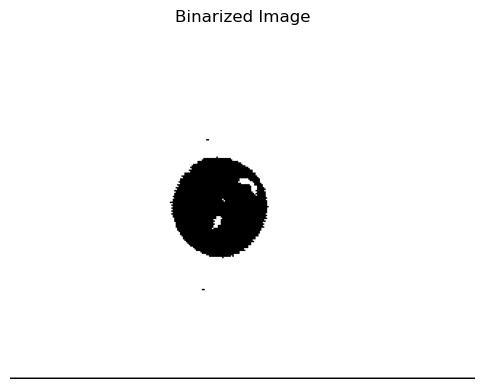

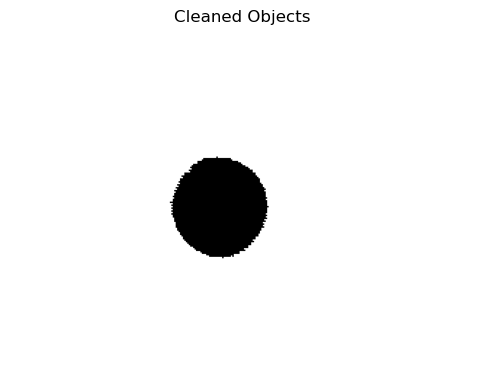

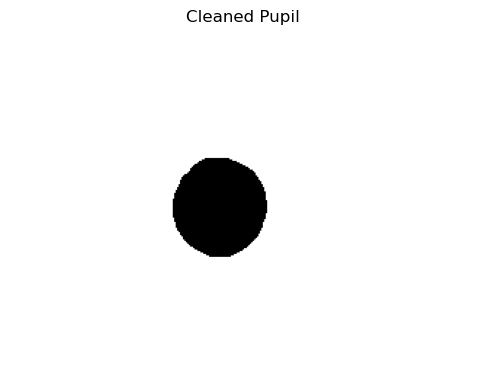

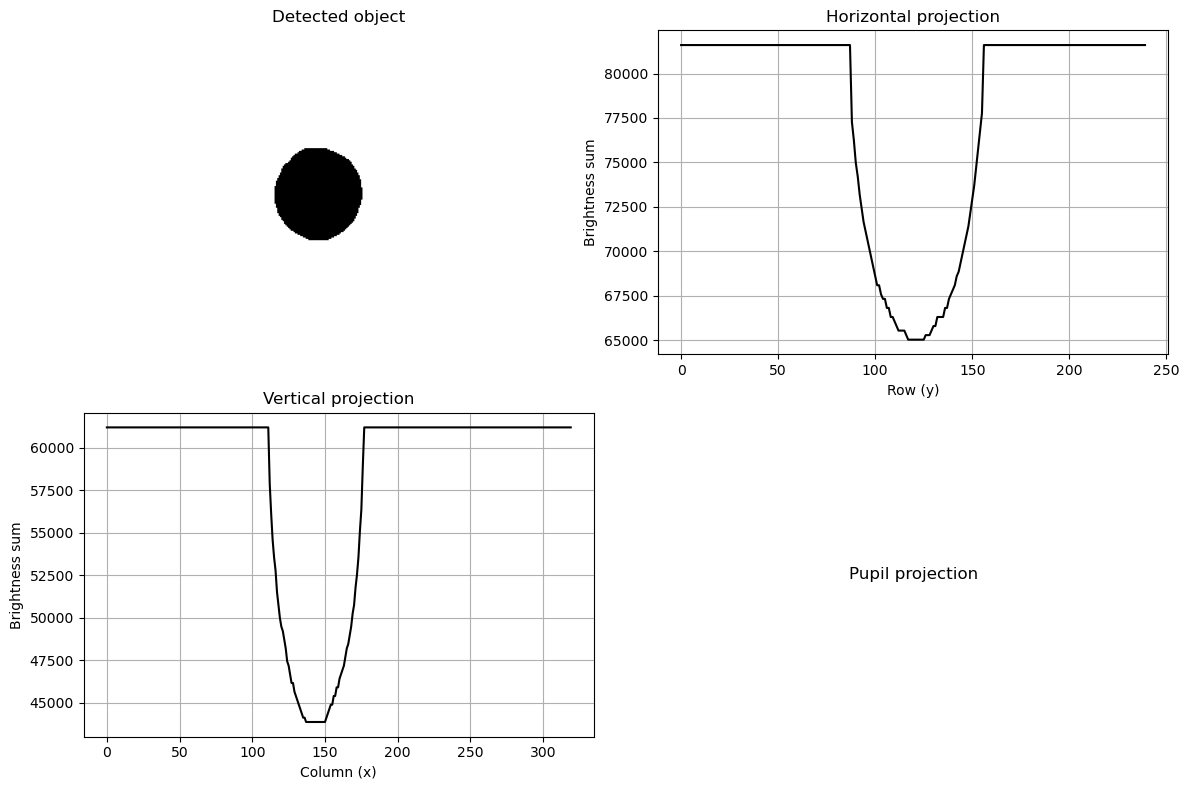

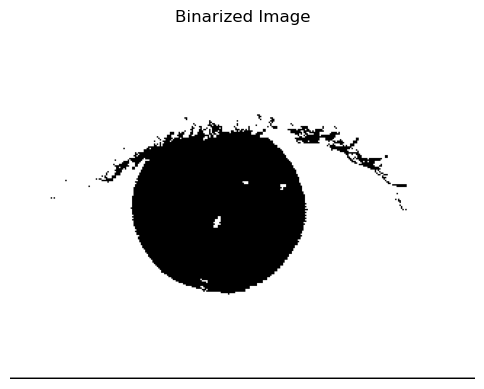

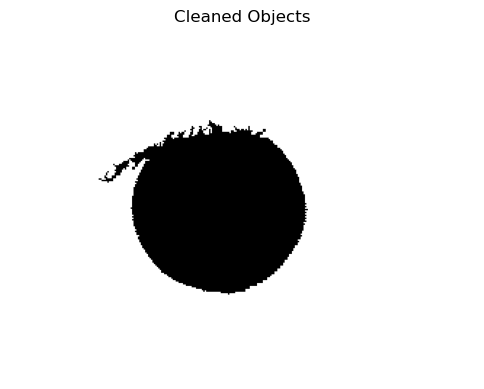

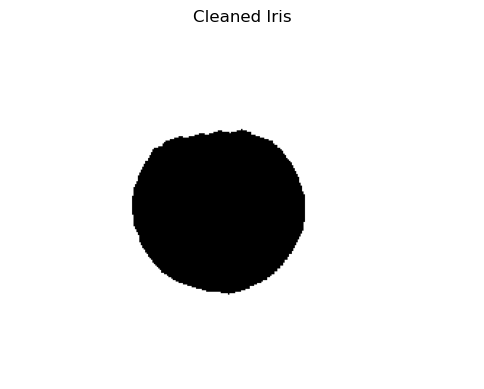

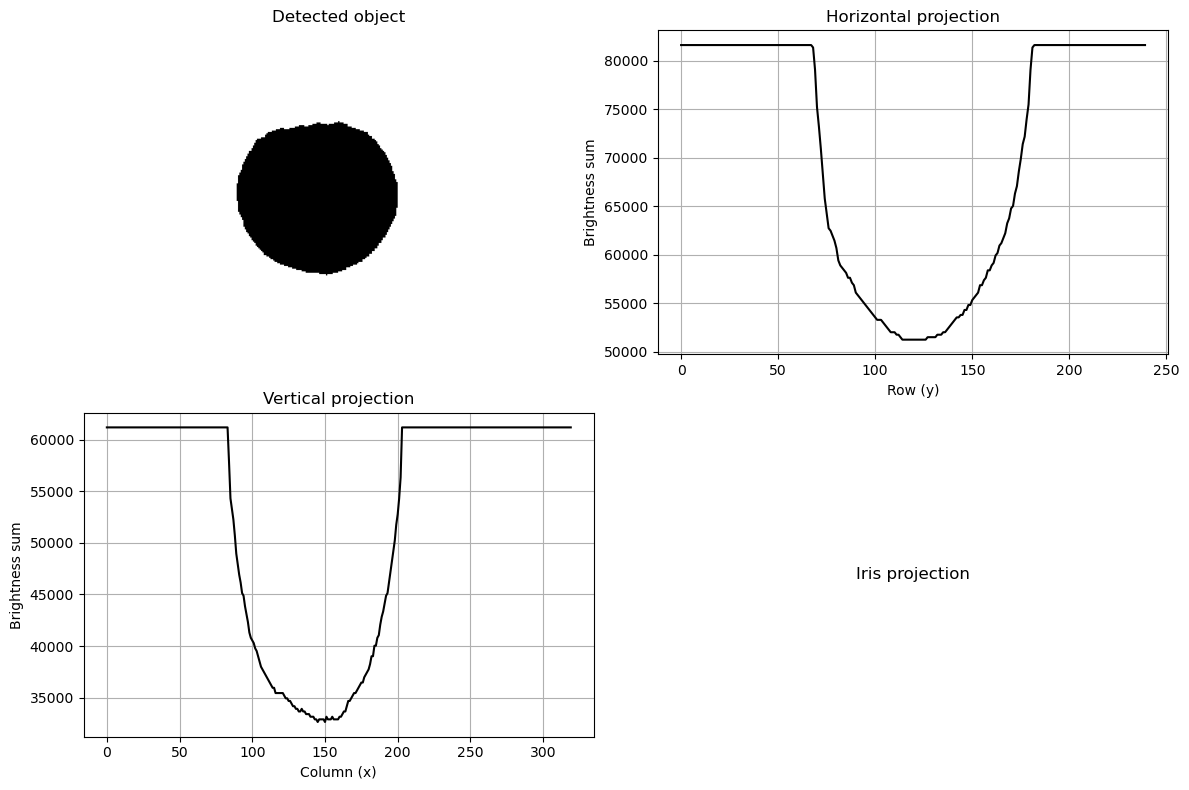

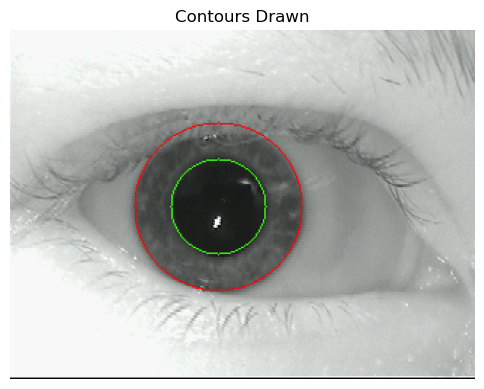

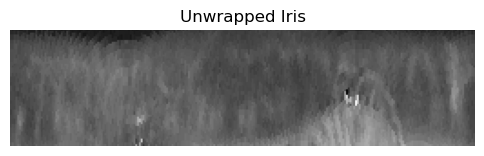

In [84]:
processor = IrisSegmenter("./data/MMU-Iris-Database/10/right/fionar5.bmp")
processor.process(Xi=1.5, Xp=3.5)

# Small problems

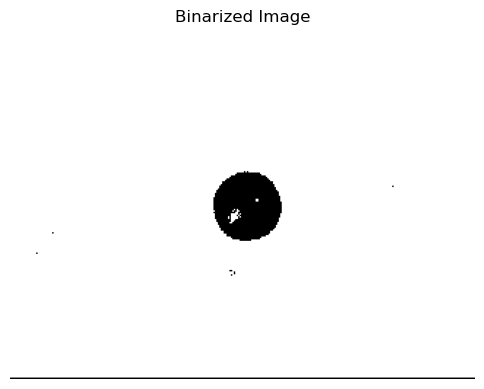

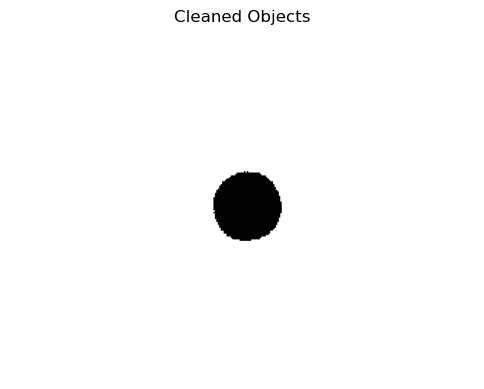

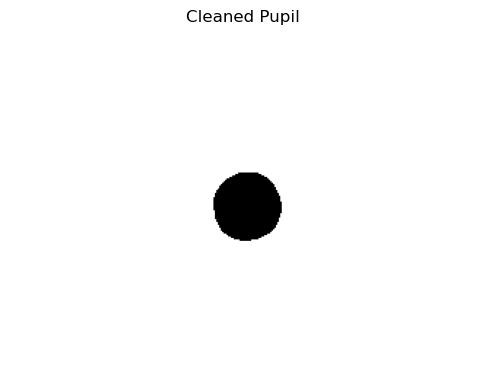

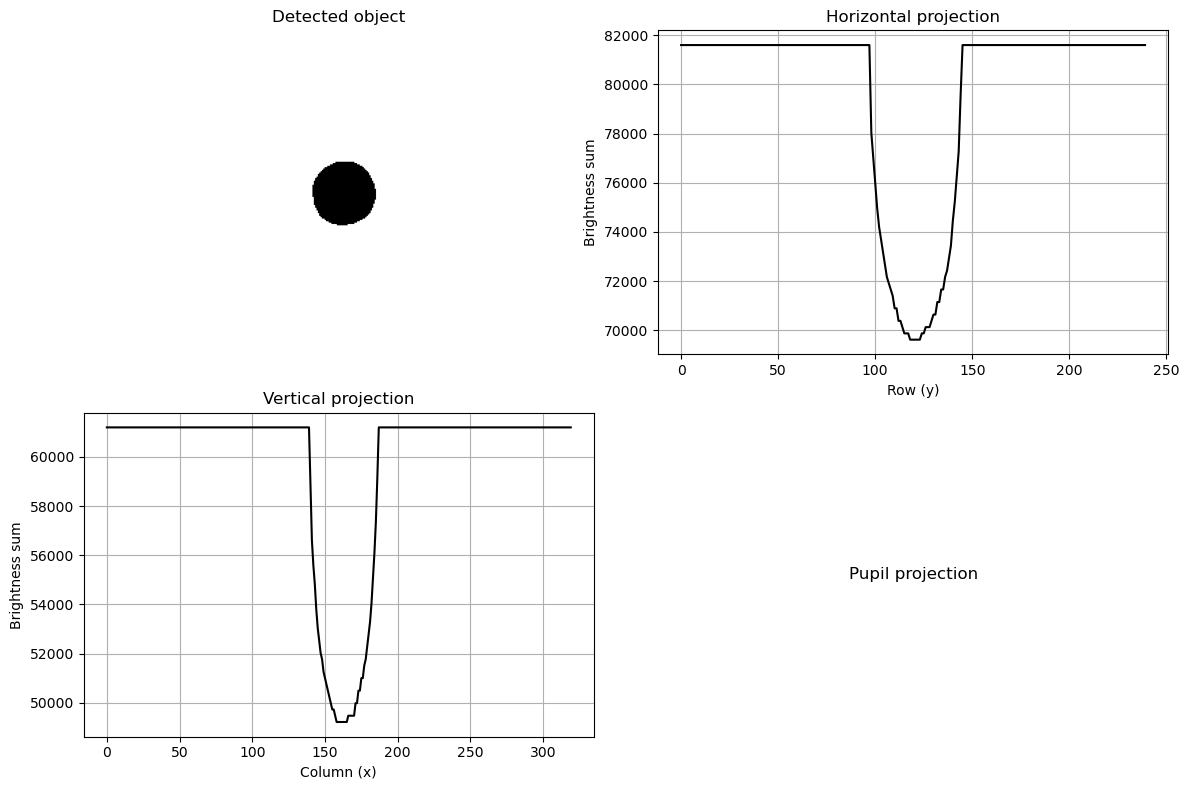

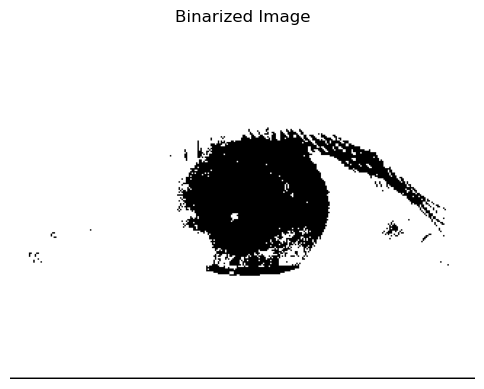

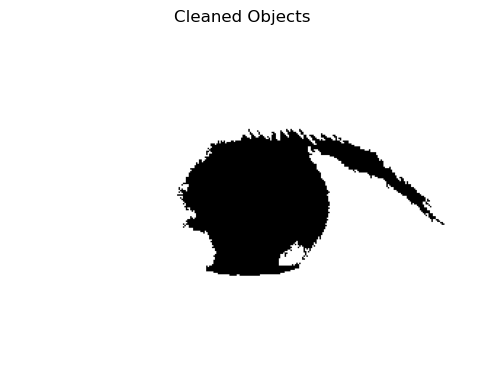

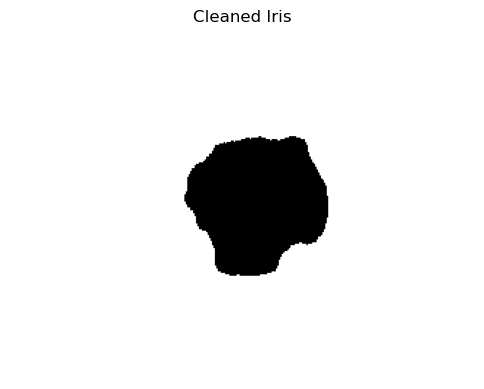

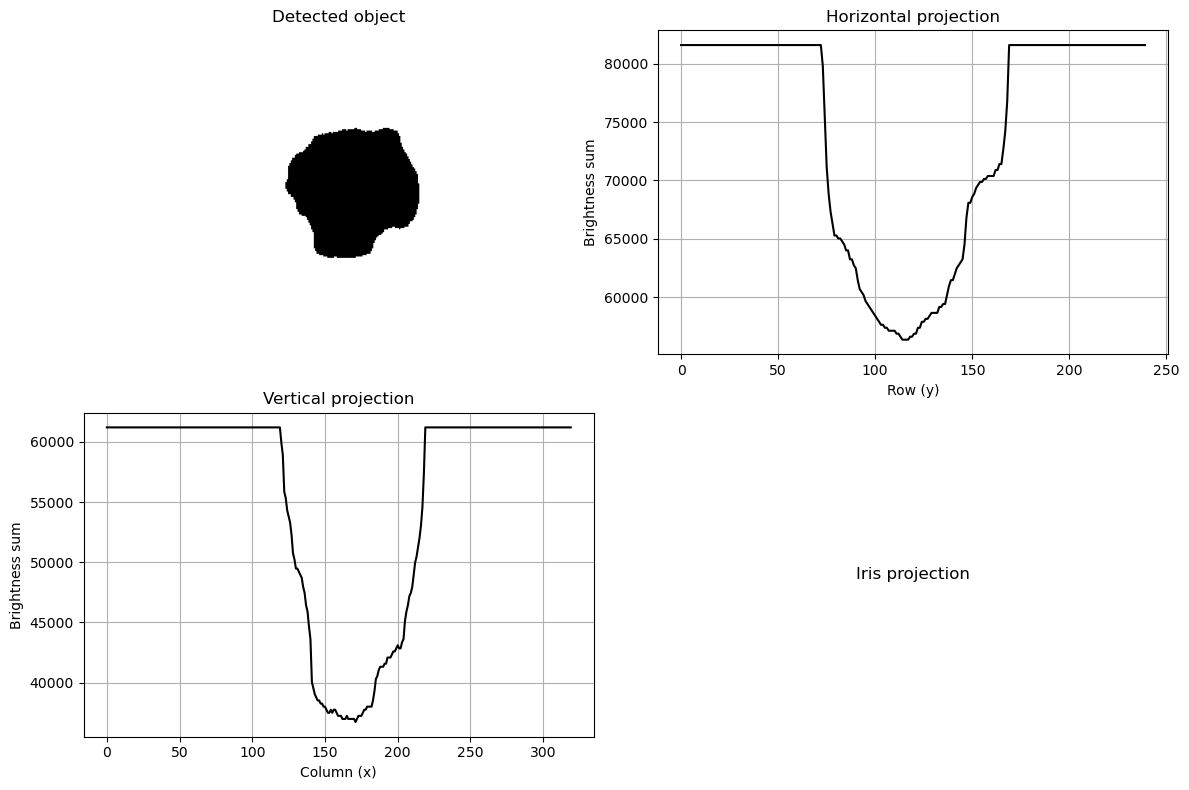

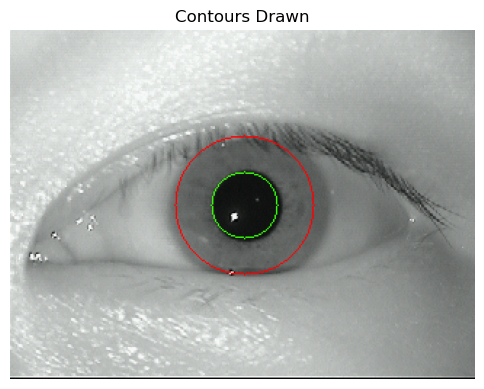

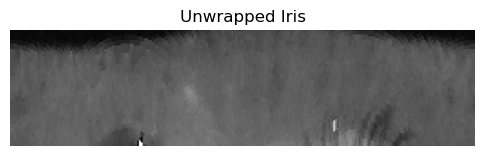

In [85]:
processor = IrisSegmenter("./data/MMU-Iris-Database/24/left/ngkokwhyl2.bmp")
processor.process(Xi=1.633, Xp=5.0)